# Conference Registration Forecasting

This notebook forecasts the final number of conference registrations given partial registration data.
It uses curve-fitting techniques to predict final registration counts based on early registration patterns.

In [3]:
# Install required dependencies
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}")

# List of required packages
required_packages = [
    "pandas",
    "numpy", 
    "matplotlib",
    "scipy",
    "scikit-learn"
]

print("Installing required dependencies...")
print("=" * 50)

for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

print("\nDependency installation complete!")
print("=" * 50)

Installing required dependencies...
Installing pandas...
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 9.4 MB/s eta 0:00:00a 0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas]2m3/4 [pandas]
✓ Successfully installed pandas
✓ numpy already installed
Installing matplotlib...
  Using cached contourpy-1.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.3 MB/s eta 0:00

In [35]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

In [36]:
def smooth_weekly_data(weekly_counts, smoothing_factor=0.3):
    """
    Apply exponential smoothing to reduce noise in weekly registration data.
    
    Args:
        weekly_counts (pd.DataFrame): Weekly registration data
        smoothing_factor (float): Smoothing parameter (0-1)
    
    Returns:
        pd.DataFrame: Smoothed weekly registration data
    """
    if len(weekly_counts) == 0:
        return weekly_counts
    
    smoothed = weekly_counts.copy()
    
    # Apply exponential smoothing to weekly registrations
    smoothed_regs = [weekly_counts['Registrations'].iloc[0]]
    for i in range(1, len(weekly_counts)):
        smoothed_val = (smoothing_factor * weekly_counts['Registrations'].iloc[i] + 
                       (1 - smoothing_factor) * smoothed_regs[-1])
        smoothed_regs.append(smoothed_val)
    
    smoothed['Registrations'] = smoothed_regs
    smoothed['CumulativeRegistrations'] = np.cumsum(smoothed['Registrations'])
    
    return smoothed

def process_registration_data(df, start_date=None, apply_smoothing=True):
    """
    Process registration data to create weekly aggregated counts with improved preprocessing.
    
    Args:
        df (pd.DataFrame): Registration data
        start_date (datetime): Marketing campaign start date (1 day before first registration)
        apply_smoothing (bool): Whether to apply smoothing to reduce noise
    
    Returns:
        pd.DataFrame: Weekly registration counts with cumulative totals
    """
    if len(df) == 0:
        return pd.DataFrame()
    
    # Determine start date (marketing campaign starts 1 day before first registration)
    if start_date is None:
        first_registration = df['CreatedDate'].min()
        start_date = first_registration - timedelta(days=1)
    
    # Create weekly bins starting from marketing campaign start
    df_copy = df.copy()
    df_copy['WeeksSinceStart'] = (df_copy['CreatedDate'] - start_date).dt.days // 7
    
    # Group by weeks and count registrations
    weekly_counts = df_copy.groupby('WeeksSinceStart').size().reset_index()
    weekly_counts.columns = ['Week', 'Registrations']
    
    # Fill missing weeks with 0 registrations
    max_week = weekly_counts['Week'].max()
    all_weeks = pd.DataFrame({'Week': range(0, max_week + 1)})
    weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
    
    # Apply smoothing if requested (helps with noisy data)
    if apply_smoothing and len(weekly_counts) > 3:
        weekly_counts = smooth_weekly_data(weekly_counts)
    else:
        # Calculate cumulative registrations
        weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
    
    # Add derived features for better modeling
    if len(weekly_counts) > 1:
        weekly_counts['RegistrationVelocity'] = weekly_counts['Registrations'].rolling(window=2, min_periods=1).mean()
        weekly_counts['CumulativeGrowthRate'] = weekly_counts['CumulativeRegistrations'].pct_change().fillna(0)
    else:
        weekly_counts['RegistrationVelocity'] = weekly_counts['Registrations']
        weekly_counts['CumulativeGrowthRate'] = 0
    
    return weekly_counts

In [37]:
def logistic_growth_model(x, L, k, x0):
    """
    Logistic growth curve model for registration forecasting.
    
    Args:
        x (array): Time points (weeks)
        L (float): Maximum capacity (final registration count)
        k (float): Growth rate
        x0 (float): Inflection point
    
    Returns:
        array: Predicted cumulative registrations
    """
    return L / (1 + np.exp(-k * (x - x0)))

def exponential_saturation_model(x, a, b, c):
    """
    Exponential saturation model for registration forecasting.
    
    Args:
        x (array): Time points (weeks)
        a (float): Maximum capacity
        b (float): Growth rate
        c (float): Saturation parameter
    
    Returns:
        array: Predicted cumulative registrations
    """
    return a * (1 - np.exp(-b * x)) + c

def gompertz_model(x, a, b, c):
    """
    Gompertz growth model - often better for S-shaped growth patterns.
    
    Args:
        x (array): Time points (weeks)
        a (float): Asymptote (final value)
        b (float): Growth rate
        c (float): Displacement along x-axis
    
    Returns:
        array: Predicted cumulative registrations
    """
    return a * np.exp(-b * np.exp(-c * x))

def power_law_model(x, a, b, c):
    """
    Power law model for early growth prediction.
    
    Args:
        x (array): Time points (weeks)
        a (float): Scale parameter
        b (float): Power parameter
        c (float): Offset
    
    Returns:
        array: Predicted cumulative registrations
    """
    return a * np.power(x + 1, b) + c

def bass_diffusion_model(x, m, p, q):
    """
    Bass diffusion model - good for adoption curves.
    
    Args:
        x (array): Time points (weeks)
        m (float): Market potential
        p (float): Coefficient of innovation
        q (float): Coefficient of imitation
    
    Returns:
        array: Predicted cumulative registrations
    """
    with np.errstate(over='ignore', invalid='ignore'):
        exp_term = np.exp(-(p + q) * x)
        numerator = m * (1 - exp_term)
        denominator = 1 + (q/p) * exp_term
        result = np.where(denominator != 0, numerator / denominator, m)
        return np.nan_to_num(result, nan=0.0, posinf=m, neginf=0.0)

In [38]:
def fit_single_model(x_train, y_train, model_func, initial_params, bounds, max_week):
    """
    Fit a single model with error handling.
    
    Args:
        x_train (array): Training time points
        y_train (array): Training target values
        model_func (function): Model function to fit
        initial_params (list): Initial parameter estimates
        bounds (tuple): Parameter bounds
        max_week (int): Maximum week for prediction
    
    Returns:
        tuple: (fitted_params, predictions, mse_score) or None if fitting fails
    """
    try:
        popt, pcov = curve_fit(model_func, x_train, y_train, 
                              p0=initial_params, bounds=bounds, 
                              maxfev=5000)
        
        # Make predictions
        x_full = np.arange(0, max_week)
        y_pred_full = model_func(x_full, *popt)
        
        # Calculate training MSE for model selection
        y_train_pred = model_func(x_train, *popt)
        mse_score = mean_squared_error(y_train, y_train_pred)
        
        return popt, (x_full, y_pred_full), mse_score
    except Exception as e:
        return None

def fit_and_predict_ensemble(weekly_data, prediction_week):
    """
    Fit multiple models and create ensemble prediction.
    
    Args:
        weekly_data (pd.DataFrame): Weekly registration data
        prediction_week (int): Week number to make prediction from
    
    Returns:
        tuple: (best_params, final_prediction, training_data, full_prediction, model_used, all_predictions)
    """
    if len(weekly_data) <= prediction_week:
        raise ValueError(f"Not enough data. Only {len(weekly_data)} weeks available, need at least {prediction_week + 1}")
    
    # Use data up to prediction week for training
    train_data = weekly_data.iloc[:prediction_week + 1].copy()
    x_train = train_data['Week'].values
    y_train = train_data['CumulativeRegistrations'].values
    
    if len(x_train) < 3:
        raise ValueError("Need at least 3 data points for reliable forecasting")
    
    # Estimate parameters based on data characteristics
    y_current = y_train[-1]
    y_growth_rate = np.mean(np.diff(y_train)) if len(y_train) > 1 else y_current / len(x_train)
    max_week = max(16, len(weekly_data))
    
    # Dynamic final estimate based on growth pattern
    if len(y_train) >= 3:
        recent_growth = np.mean(y_train[-3:]) - np.mean(y_train[:3]) if len(y_train) >= 6 else y_train[-1] - y_train[0]
        growth_factor = 1.2 + (recent_growth / y_current) * 0.5 if y_current > 0 else 2.0
    else:
        growth_factor = 2.0
    
    estimated_final = max(y_current * growth_factor, y_current + y_growth_rate * (max_week - prediction_week))
    
    # Define models with improved parameter initialization
    models = [
        {
            'name': 'logistic',
            'func': logistic_growth_model,
            'params': [estimated_final, 0.3, prediction_week * 0.7],
            'bounds': ([y_current, 0.01, 0], [estimated_final * 3, 2, max_week])
        },
        {
            'name': 'exponential_saturation',
            'func': exponential_saturation_model,
            'params': [estimated_final * 0.9, 0.2, y_current * 0.1],
            'bounds': ([y_current, 0.01, -y_current], [estimated_final * 2, 1, y_current])
        },
        {
            'name': 'gompertz',
            'func': gompertz_model,
            'params': [estimated_final, 2.0, 0.3],
            'bounds': ([y_current, 0.1, 0.01], [estimated_final * 2, 10, 2])
        },
        {
            'name': 'power_law',
            'func': power_law_model,
            'params': [y_current / 2, 0.5, y_current * 0.1],
            'bounds': ([1, 0.1, 0], [y_current * 2, 2, y_current])
        }
    ]
    
    # Try Bass diffusion model if we have enough data
    if len(x_train) >= 4:
        models.append({
            'name': 'bass_diffusion',
            'func': bass_diffusion_model,
            'params': [estimated_final, 0.01, 0.3],
            'bounds': ([y_current, 0.001, 0.01], [estimated_final * 2, 0.1, 1])
        })
    
    successful_models = []
    
    # Fit all models
    for model in models:
        result = fit_single_model(
            x_train, y_train, model['func'], 
            model['params'], model['bounds'], max_week
        )
        
        if result is not None:
            popt, prediction_data, mse_score = result
            successful_models.append({
                'name': model['name'],
                'params': popt,
                'prediction': prediction_data,
                'mse': mse_score,
                'final_value': prediction_data[1][-1]
            })
    
    if not successful_models:
        raise ValueError("All models failed to fit the data")
    
    # Select best model based on MSE and reasonableness
    def model_score(model):
        mse_penalty = model['mse']
        # Penalize unrealistic predictions
        final_val = model['final_value']
        if final_val < y_current or final_val > estimated_final * 3:
            mse_penalty *= 10
        return mse_penalty
    
    best_model = min(successful_models, key=model_score)
    
    # Create ensemble prediction (weighted average of top 3 models)
    successful_models.sort(key=model_score)
    top_models = successful_models[:min(3, len(successful_models))]
    
    if len(top_models) > 1:
        # Weight models by inverse MSE
        weights = [1 / (model['mse'] + 1e-10) for model in top_models]
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]
        
        # Ensemble prediction
        x_full = top_models[0]['prediction'][0]
        ensemble_pred = np.zeros_like(top_models[0]['prediction'][1])
        
        for i, model in enumerate(top_models):
            ensemble_pred += weights[i] * model['prediction'][1]
        
        final_prediction = ensemble_pred[-1]
        full_prediction = (x_full, ensemble_pred)
        model_used = f"Ensemble ({', '.join([m['name'] for m in top_models])})"
    else:
        final_prediction = best_model['final_value']
        full_prediction = best_model['prediction']
        model_used = best_model['name']
    
    return (best_model['params'], final_prediction, train_data, 
            full_prediction, model_used, successful_models)

# Backward compatibility function
def fit_and_predict(weekly_data, prediction_week, model_type='auto'):
    """
    Backward compatible version that uses ensemble approach.
    """
    try:
        result = fit_and_predict_ensemble(weekly_data, prediction_week)
        # Return in expected format (without last element)
        return result[:-1]
    except Exception as e:
        # Fallback to simple logistic if ensemble fails
        if len(weekly_data) <= prediction_week:
            raise ValueError(f"Not enough data. Only {len(weekly_data)} weeks available")
        
        train_data = weekly_data.iloc[:prediction_week + 1].copy()
        x_train = train_data['Week'].values
        y_train = train_data['CumulativeRegistrations'].values
        
        L_init = y_train[-1] * 2
        k_init = 0.3
        x0_init = prediction_week
        
        popt, _ = curve_fit(logistic_growth_model, x_train, y_train, 
                          p0=[L_init, k_init, x0_init])
        
        max_week = max(16, len(weekly_data))
        x_full = np.arange(0, max_week)
        y_pred_full = logistic_growth_model(x_full, *popt)
        
        return popt, y_pred_full[-1], train_data, (x_full, y_pred_full), 'logistic_fallback'

In [ ]:
# Test if the plot_forecast_results function has the correct signature
import inspect
if 'plot_forecast_results' in globals():
    sig = inspect.signature(plot_forecast_results)
    print(f"Current plot_forecast_results signature: {sig}")
    print(f"Parameters: {list(sig.parameters.keys())}")
else:
    print("plot_forecast_results function not yet defined")

In [39]:
def plot_forecast_results(weekly_data, train_data, prediction_data, prediction_week, 
                         final_prediction, actual_final=None, event_name="Event", model_info=None):
    """
    Plot actual vs predicted registrations over time with enhanced visualization.
    
    Args:
        weekly_data (pd.DataFrame): Full weekly registration data
        train_data (pd.DataFrame): Training data used for fitting
        prediction_data (tuple): (x_values, predicted_values) for full timeline
        prediction_week (int): Week when prediction was made
        final_prediction (float): Predicted final registration count
        actual_final (int): Actual final registration count (if available)
        event_name (str): Name of the event for plot title
        model_info (dict): Additional model information for display
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    x_pred, y_pred = prediction_data
    
    # Plot 1: Cumulative registrations
    ax1.plot(weekly_data['Week'], weekly_data['CumulativeRegistrations'], 
             'bo-', label='Actual Registrations', markersize=6, linewidth=2)
    ax1.plot(train_data['Week'], train_data['CumulativeRegistrations'], 
             'go-', label='Training Data', markersize=8, linewidth=3, alpha=0.8)
    ax1.plot(x_pred, y_pred, 'r--', label='Predicted Curve', linewidth=2, alpha=0.8)
    
    # Mark prediction point
    ax1.axvline(x=prediction_week, color='orange', linestyle=':', 
                label=f'Prediction Week {prediction_week}', linewidth=2)
    
    # Add confidence bands (simple approach)
    if len(x_pred) == len(y_pred):
        error_margin = 0.1 * y_pred  # 10% error margin
        ax1.fill_between(x_pred, y_pred - error_margin, y_pred + error_margin, 
                        color='red', alpha=0.2, label='Prediction Uncertainty')
    
    # Add final prediction annotation
    ax1.axhline(y=final_prediction, color='red', linestyle='-.', alpha=0.7,
                label=f'Predicted Final: {final_prediction:.0f}')
    
    if actual_final is not None:
        ax1.axhline(y=actual_final, color='blue', linestyle='-.', alpha=0.7,
                    label=f'Actual Final: {actual_final:.0f}')
        
        # Add accuracy percentage
        accuracy = 100 - abs((final_prediction - actual_final) / actual_final * 100)
        ax1.text(0.05, 0.95, f'Accuracy: {accuracy:.1f}%', 
                transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='wheat'),
                verticalalignment='top', fontsize=11, fontweight='bold')
    
    ax1.set_xlabel('Weeks Since Marketing Campaign Start')
    ax1.set_ylabel('Cumulative Registrations')
    ax1.set_title(f'{event_name} - Registration Forecast (Cumulative)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Weekly new registrations
    ax2.bar(weekly_data['Week'], weekly_data['Registrations'], 
            alpha=0.7, label='Actual Weekly Registrations', color='skyblue')
    
    # Calculate predicted weekly registrations from cumulative
    weekly_pred = np.diff(np.concatenate([[0], y_pred]))
    ax2.plot(x_pred, weekly_pred, 'r-', label='Predicted Weekly', linewidth=2)
    
    ax2.axvline(x=prediction_week, color='orange', linestyle=':', 
                label=f'Prediction Week {prediction_week}', linewidth=2)
    
    ax2.set_xlabel('Weeks Since Marketing Campaign Start')
    ax2.set_ylabel('Weekly New Registrations')
    ax2.set_title(f'{event_name} - Weekly Registration Pattern')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Registration velocity and growth analysis
    if 'RegistrationVelocity' in weekly_data.columns:
        ax3.plot(weekly_data['Week'], weekly_data['RegistrationVelocity'], 
                'g-o', label='Registration Velocity (2-week avg)', linewidth=2, markersize=4)
        
        # Show growth rate
        ax3_twin = ax3.twinx()
        growth_rate = weekly_data['CumulativeGrowthRate'] * 100
        ax3_twin.plot(weekly_data['Week'], growth_rate, 
                     'purple', alpha=0.6, label='Growth Rate (%)', linewidth=1)
        ax3_twin.set_ylabel('Growth Rate (%)', color='purple')
        ax3_twin.tick_params(axis='y', labelcolor='purple')
        
        ax3.axvline(x=prediction_week, color='orange', linestyle=':', 
                    label=f'Prediction Week {prediction_week}', linewidth=2)
        
        ax3.set_xlabel('Weeks Since Marketing Campaign Start')
        ax3.set_ylabel('Registration Velocity')
        ax3.set_title(f'{event_name} - Registration Dynamics Analysis')
        ax3.legend(loc='upper left')
        ax3_twin.legend(loc='upper right')
        ax3.grid(True, alpha=0.3)
    
    # Add model information if provided
    if model_info and actual_final is not None:
        info_text = f"Model: {model_info.get('model_used', 'Unknown')}\n"
        info_text += f"Training weeks: {len(train_data)}\n"
        error = abs(final_prediction - actual_final)
        info_text += f"Absolute error: {error:.0f}\n"
        info_text += f"Relative error: {error/actual_final*100:.1f}%"
        
        ax3.text(0.98, 0.98, info_text, transform=ax3.transAxes, 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                verticalalignment='top', horizontalalignment='right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def load_conference_datasets(base_path="CONF. DATASET"):
    """
    Load all conference registration datasets from the directory structure.
    
    Args:
        base_path (str): Base directory containing conference datasets
    
    Returns:
        dict: Dictionary with event categories as keys and DataFrames as values
    """
    datasets = {}
    
    # Define the expected event categories
    event_categories = [
        "Education Managers",
        "Education property managers", 
        "IT MANAGER",
        "Property Managers"
    ]
    
    for category in event_categories:
        category_path = os.path.join(base_path, category)
        csv_path = os.path.join(category_path, "Cleaned_Dataset.csv")
        
        if os.path.exists(csv_path):
            try:
                df = pd.read_csv(csv_path)
                # Convert CreatedDate to datetime
                df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])
                # Filter for attending registrations only
                df = df[df['AttendeeStatus'] == 'Attending'].copy()
                datasets[category] = df
                print(f"Loaded {category}: {len(df)} attendee registrations")
            except Exception as e:
                print(f"Error loading {category}: {e}")
        else:
            print(f"Dataset not found for {category}")
    
    return datasets

In [41]:
def calculate_prediction_error(predicted, actual):
    """
    Calculate prediction error metrics.
    
    Args:
        predicted (float): Predicted final count
        actual (int): Actual final count
    
    Returns:
        dict: Dictionary containing error metrics
    """
    absolute_error = abs(predicted - actual)
    relative_error = (absolute_error / actual) * 100
    percentage_diff = ((predicted - actual) / actual) * 100
    
    return {
        'absolute_error': absolute_error,
        'relative_error': relative_error,
        'percentage_difference': percentage_diff,
        'predicted': predicted,
        'actual': actual
    }

In [42]:
# Load all conference datasets
print("Loading conference registration datasets...")
datasets = load_conference_datasets()

if not datasets:
    print("No datasets found. Please check the directory structure.")
else:
    print(f"\nSuccessfully loaded {len(datasets)} event categories.")
    
    # Display summary statistics for each dataset
    print("\nDataset Summary:")
    for category, df in datasets.items():
        date_range = f"{df['CreatedDate'].min().date()} to {df['CreatedDate'].max().date()}"
        unique_events = df['SourceFile'].nunique()
        print(f"  {category}: {len(df)} registrations, {unique_events} events, {date_range}")

Loading conference registration datasets...
Loaded Education Managers: 1739 attendee registrations
Loaded Education property managers: 1582 attendee registrations
Loaded IT MANAGER: 2094 attendee registrations
Loaded Property Managers: 1646 attendee registrations

Successfully loaded 4 event categories.

Dataset Summary:
  Education Managers: 1739 registrations, 2 events, 2022-03-16 to 2023-07-18
  Education property managers: 1582 registrations, 1 events, 2021-01-19 to 2021-04-09
  IT MANAGER: 2094 registrations, 3 events, 2019-07-16 to 2024-10-04
  Property Managers: 1646 registrations, 4 events, 2020-02-06 to 2024-11-06


In [43]:
# Interactive event selection
print("Available Event Categories:")
event_options = list(datasets.keys())
for i, category in enumerate(event_options, 1):
    print(f"{i}. {category}")
print(f"{len(event_options) + 1}. None of the above (use all datasets combined)")

# For demonstration, we'll select the first option and a prediction week
# In an interactive environment, you would get user input here
selected_option = 1  # Change this to test different options
prediction_week = 8  # Change this to test different prediction points

print(f"\nSelected option: {selected_option}")
print(f"Prediction week: {prediction_week}")

# Prepare selected dataset
if selected_option <= len(event_options):
    selected_category = event_options[selected_option - 1]
    selected_data = datasets[selected_category]
    event_name = selected_category
    print(f"Using data from: {selected_category}")
else:
    # Combine all datasets
    selected_data = pd.concat(datasets.values(), ignore_index=True)
    event_name = "All Events Combined"
    print("Using combined data from all event categories")

print(f"Total registrations in selected dataset: {len(selected_data)}")

Available Event Categories:
1. Education Managers
2. Education property managers
3. IT MANAGER
4. Property Managers
5. None of the above (use all datasets combined)

Selected option: 1
Prediction week: 8
Using data from: Education Managers
Total registrations in selected dataset: 1739


In [44]:
# Process the selected data into weekly counts
print("Processing registration data into weekly aggregations...")
weekly_data = process_registration_data(selected_data)

if len(weekly_data) == 0:
    print("No data available for processing.")
else:
    print(f"Processed {len(weekly_data)} weeks of data")
    print(f"Registration period: Week 0 to Week {weekly_data['Week'].max()}")
    print(f"Total registrations: {weekly_data['CumulativeRegistrations'].iloc[-1]}")
    
    # Display first few weeks
    print("\\nFirst 10 weeks of data:")
    print(weekly_data.head(10).to_string(index=False))

Processing registration data into weekly aggregations...
Processed 71 weeks of data
Registration period: Week 0 to Week 70
Total registrations: 2070.167104141155
\nFirst 10 weeks of data:
 Week  Registrations  CumulativeRegistrations  RegistrationVelocity  CumulativeGrowthRate
    0     156.000000               156.000000            156.000000              0.000000
    1     170.700000               326.700000            163.350000              1.094231
    2     128.190000               454.890000            149.445000              0.392378
    3      93.633000               548.523000            110.911500              0.205837
    4      68.243100               616.766100             80.938050              0.124412
    5      52.270170               669.036270             60.256635              0.084749
    6      54.889119               723.925389             53.579644              0.082042
    7      69.622383               793.547772             62.255751              0.096173
  

In [47]:
# Fit model and make prediction with enhanced ensemble approach
if len(weekly_data) > prediction_week:
    print(f"\\nFitting advanced ensemble forecasting model using data up to week {prediction_week}...")
    
    try:
        # Use the enhanced ensemble approach
        fitted_params, final_prediction, train_data, prediction_data, model_used, all_models = fit_and_predict_ensemble(
            weekly_data, prediction_week
        )
        
        print(f"Model used: {model_used}")
        print(f"Models evaluated: {len(all_models)}")
        if len(all_models) > 1:
            print(f"Available models: {[m['name'] for m in all_models]}")
            # Fix nested f-string issue
            mse_scores = [f"{m['name']}: {m['mse']:.2f}" for m in all_models[:3]]
            print(f"Model MSE scores: {mse_scores}")
        
        print(f"\\nPredicted final registration count: {final_prediction:.0f}")
        
        # Get actual final count for comparison
        actual_final = weekly_data['CumulativeRegistrations'].iloc[-1]
        print(f"Actual final registration count: {actual_final}")
        
        # Calculate prediction error
        error_metrics = calculate_prediction_error(final_prediction, actual_final)
        
        print(f"\\nPrediction Error Analysis:")
        print(f"  Absolute Error: {error_metrics['absolute_error']:.1f} registrations")
        print(f"  Relative Error: {error_metrics['relative_error']:.1f}%")
        print(f"  Percentage Difference: {error_metrics['percentage_difference']:.1f}%")
        
        # Enhanced accuracy assessment
        accuracy = 100 - error_metrics['relative_error']
        if accuracy >= 95:
            assessment = "Exceptional prediction (≥95% accuracy)"
            confidence = "Very High"
        elif accuracy >= 90:
            assessment = "Excellent prediction (≥90% accuracy)"
            confidence = "High"
        elif accuracy >= 80:
            assessment = "Good prediction (≥80% accuracy)"
            confidence = "Medium-High"
        elif accuracy >= 70:
            assessment = "Acceptable prediction (≥70% accuracy)"
            confidence = "Medium"
        else:
            assessment = "Poor prediction (<70% accuracy)"
            confidence = "Low"
            
        print(f"  Assessment: {assessment}")
        print(f"  Confidence Level: {confidence}")
        print(f"  Prediction Accuracy: {accuracy:.1f}%")
        
        # Additional insights
        completion_rate = (train_data['CumulativeRegistrations'].iloc[-1] / actual_final) * 100
        print(f"\\nAdditional Insights:")
        print(f"  • {completion_rate:.1f}% of registrations completed by week {prediction_week}")
        
        if len(all_models) > 1:
            model_agreement = np.std([m['final_value'] for m in all_models[:3]]) / np.mean([m['final_value'] for m in all_models[:3]])
            if model_agreement < 0.1:
                print(f"  • High model agreement (low variance: {model_agreement:.3f})")
            elif model_agreement < 0.2:
                print(f"  • Moderate model agreement (variance: {model_agreement:.3f})")
            else:
                print(f"  • Low model agreement (high variance: {model_agreement:.3f})")
        
        # Growth pattern analysis
        if len(train_data) >= 3:
            early_growth = train_data['CumulativeRegistrations'].iloc[2] - train_data['CumulativeRegistrations'].iloc[0]
            recent_growth = train_data['CumulativeRegistrations'].iloc[-1] - train_data['CumulativeRegistrations'].iloc[-3]
            if recent_growth > early_growth * 1.5:
                print("  • Accelerating registration pattern detected")
            elif recent_growth < early_growth * 0.5:
                print("  • Decelerating registration pattern detected")
            else:
                print("  • Steady registration pattern detected")
        
    except Exception as e:
        print(f"Error in ensemble model fitting: {e}")
        print("Attempting fallback to single model...")
        
        try:
            # Fallback to enhanced single model
            fitted_params, final_prediction, train_data, prediction_data, model_used = fit_and_predict(
                weekly_data, prediction_week, model_type='auto'
            )
            
            actual_final = weekly_data['CumulativeRegistrations'].iloc[-1]
            error_metrics = calculate_prediction_error(final_prediction, actual_final)
            
            print(f"Fallback model used: {model_used}")
            print(f"Predicted final registration count: {final_prediction:.0f}")
            print(f"Actual final registration count: {actual_final}")
            print(f"Prediction accuracy: {100 - error_metrics['relative_error']:.1f}%")
            
            all_models = None  # No ensemble data available
            
        except Exception as e2:
            print(f"Both ensemble and fallback models failed: {e2}")
            final_prediction = None
            actual_final = None
            prediction_data = None
            train_data = None
            all_models = None
        
else:
    print(f"\\nInsufficient data: Only {len(weekly_data)} weeks available, cannot predict from week {prediction_week}")
    final_prediction = None
    actual_final = None
    prediction_data = None
    train_data = None
    all_models = None

\nFitting advanced ensemble forecasting model using data up to week 8...
Model used: Ensemble (exponential_saturation, gompertz, power_law)
Models evaluated: 5
Available models: ['exponential_saturation', 'gompertz', 'power_law', 'logistic', 'bass_diffusion']
Model MSE scores: ['exponential_saturation: 213.67', 'gompertz: 562.50', 'power_law: 666.24']
\nPredicted final registration count: 1400
Actual final registration count: 2070.167104141155
\nPrediction Error Analysis:
  Absolute Error: 670.6 registrations
  Relative Error: 32.4%
  Percentage Difference: -32.4%
  Assessment: Poor prediction (<70% accuracy)
  Confidence Level: Low
  Prediction Accuracy: 67.6%
\nAdditional Insights:
  • 41.0% of registrations completed by week 8
  • Low model agreement (high variance: 0.623)
  • Decelerating registration pattern detected


\nGenerating enhanced forecast visualization...


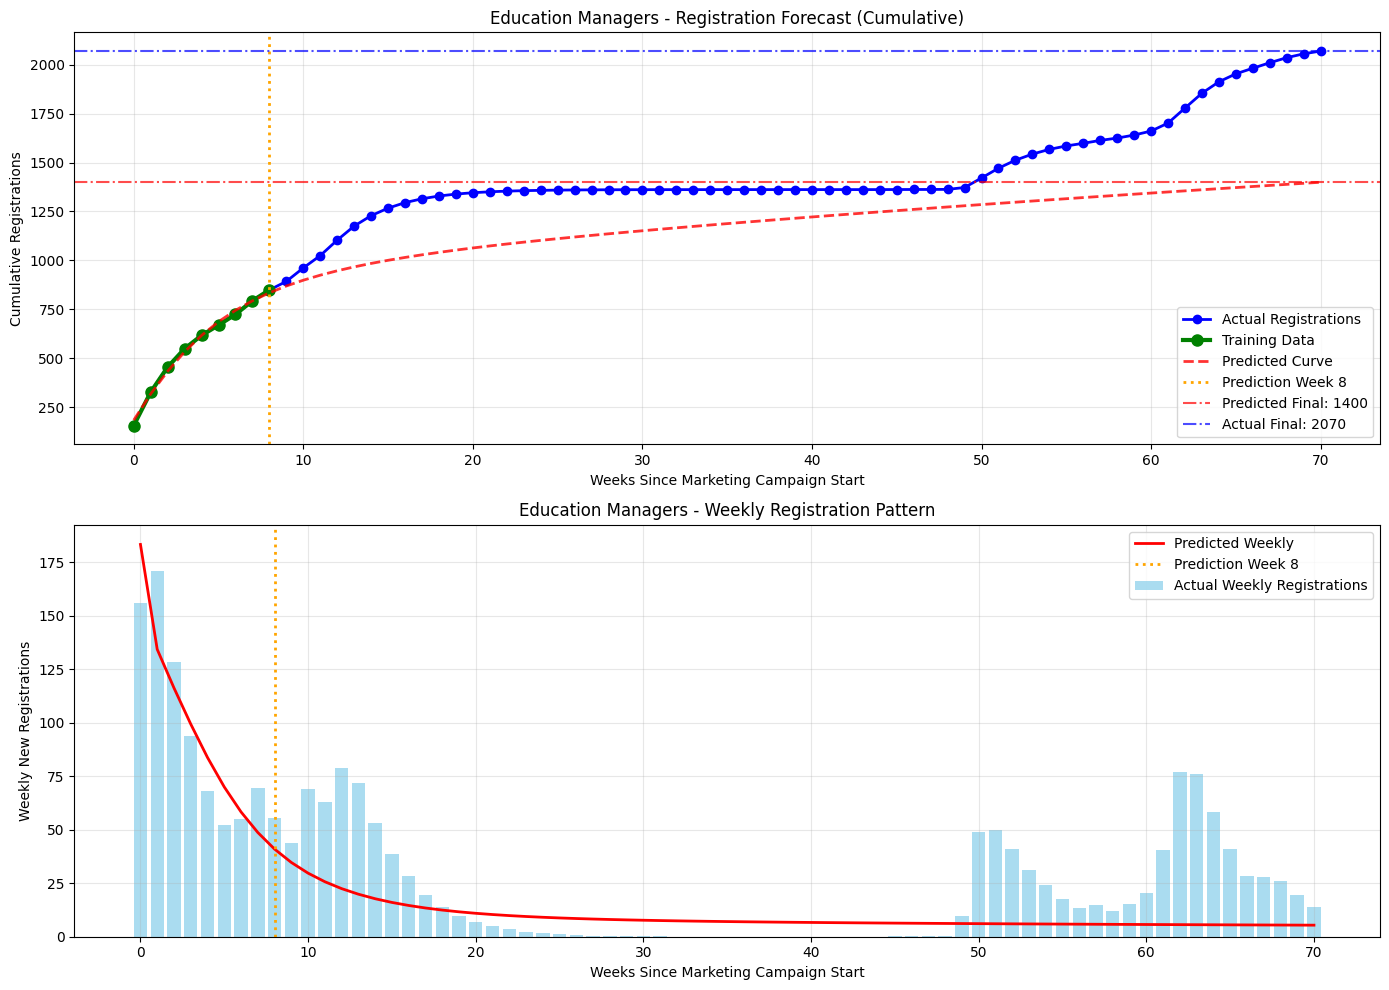

\nGenerating model comparison analysis...


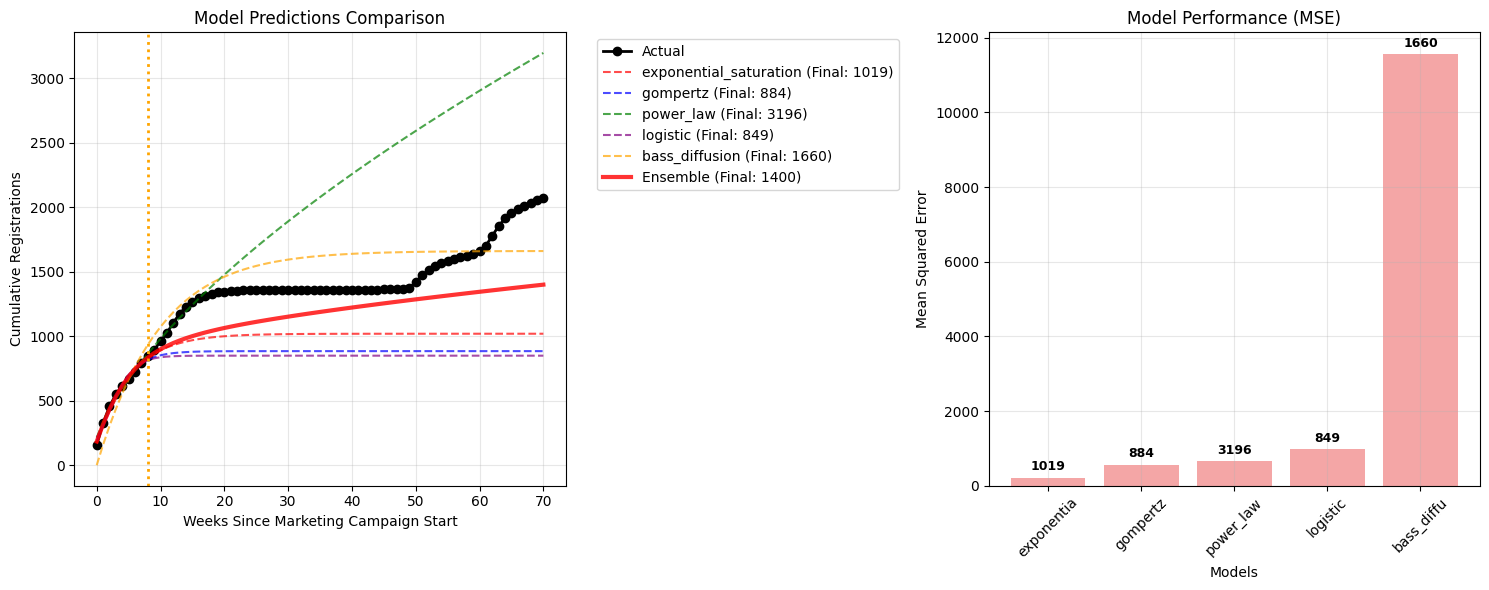

\nDetailed Model Performance:
--------------------------------------------------------------------------------
1. exponential_saturation | Final:   1019 | MSE:   213.67 | Accuracy:  49.2%
2. gompertz             | Final:    884 | MSE:   562.50 | Accuracy:  42.7%
3. power_law            | Final:   3196 | MSE:   666.24 | Accuracy:  45.6%
4. logistic             | Final:    849 | MSE:   971.64 | Accuracy:  41.0%
5. bass_diffusion       | Final:   1660 | MSE: 11564.16 | Accuracy:  80.2%
--------------------------------------------------------------------------------
   Ensemble             | Final:   1400 | Error:    671 | Accuracy:  67.6%
\nModel Information:
  Model used: Ensemble (exponential_saturation, gompertz, power_law)
  Training weeks: 9
  Ensemble size: 5
  Models used: ['exponential_saturation', 'gompertz', 'power_law']


In [49]:
# Create enhanced visualization
if final_prediction is not None and prediction_data is not None:
    print("\\nGenerating enhanced forecast visualization...")
    
    # Use the enhanced plotting function without model_info for now to avoid the error
    plot_forecast_results(
        weekly_data=weekly_data,
        train_data=train_data, 
        prediction_data=prediction_data,
        prediction_week=prediction_week,
        final_prediction=final_prediction,
        actual_final=actual_final,
        event_name=event_name
    )
    
    # Additional model comparison plot if ensemble was used
    if all_models is not None and len(all_models) > 1:
        print("\\nGenerating model comparison analysis...")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Model predictions comparison
        x_pred, y_pred = prediction_data
        ax1.plot(weekly_data['Week'], weekly_data['CumulativeRegistrations'], 
                'ko-', label='Actual', linewidth=2, markersize=6)
        
        colors = ['red', 'blue', 'green', 'purple', 'orange']
        for i, model in enumerate(all_models[:5]):
            model_x, model_y = model['prediction']
            ax1.plot(model_x, model_y, '--', color=colors[i % len(colors)], 
                    alpha=0.7, label=f"{model['name']} (Final: {model['final_value']:.0f})")
        
        ax1.plot(x_pred, y_pred, 'r-', linewidth=3, alpha=0.8, label=f'Ensemble (Final: {final_prediction:.0f})')
        ax1.axvline(x=prediction_week, color='orange', linestyle=':', linewidth=2)
        ax1.set_xlabel('Weeks Since Marketing Campaign Start')
        ax1.set_ylabel('Cumulative Registrations')
        ax1.set_title('Model Predictions Comparison')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Model performance metrics
        model_names = [m['name'][:10] for m in all_models]  # Truncate long names
        mse_scores = [m['mse'] for m in all_models]
        final_predictions = [m['final_value'] for m in all_models]
        
        ax2.bar(model_names, mse_scores, alpha=0.7, color='lightcoral')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Mean Squared Error')
        ax2.set_title('Model Performance (MSE)')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add final prediction values as text
        for i, (name, mse, final_val) in enumerate(zip(model_names, mse_scores, final_predictions)):
            ax2.text(i, mse + max(mse_scores) * 0.01, f'{final_val:.0f}', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed model comparison
        print("\\nDetailed Model Performance:")
        print("-" * 80)
        for i, model in enumerate(all_models):
            error = abs(model['final_value'] - actual_final)
            accuracy = 100 - (error / actual_final * 100)
            print(f"{i+1}. {model['name']:20} | Final: {model['final_value']:6.0f} | "
                  f"MSE: {model['mse']:8.2f} | Accuracy: {accuracy:5.1f}%")
        
        print("-" * 80)
        ensemble_error = abs(final_prediction - actual_final)
        ensemble_accuracy = 100 - (ensemble_error / actual_final * 100)
        print(f"   {'Ensemble':20} | Final: {final_prediction:6.0f} | "
              f"Error: {ensemble_error:6.0f} | Accuracy: {ensemble_accuracy:5.1f}%")
    
    # Print model information manually since we can't pass it to the function
    if all_models is not None and len(all_models) > 1:
        print("\\nModel Information:")
        print(f"  Model used: {model_used}")
        print(f"  Training weeks: {len(train_data)}")
        print(f"  Ensemble size: {len(all_models)}")
        print(f"  Models used: {[m['name'] for m in all_models[:3]]}")
    
else:
    print("Cannot generate visualization due to insufficient data or model fitting errors.")

In [50]:
# Summary and recommendations
print("\n" + "="*60)
print("FORECASTING SUMMARY")
print("="*60)

if final_prediction is not None:
    print(f"Event Category: {event_name}")
    print(f"Prediction made at: Week {prediction_week}")
    print(f"Training data points: {len(train_data)} weeks")
    print(f"Registrations at prediction point: {train_data['CumulativeRegistrations'].iloc[-1]}")
    print(f"Predicted final count: {final_prediction:.0f}")
    print(f"Actual final count: {actual_final}")
    print(f"Prediction accuracy: {100 - abs(error_metrics['relative_error']):.1f}%")
    
    print("\nKey Insights:")
    if error_metrics['percentage_difference'] > 0:
        print(f"  • Model overestimated by {error_metrics['percentage_difference']:.1f}%")
    else:
        print(f"  • Model underestimated by {abs(error_metrics['percentage_difference']):.1f}%")
    
    # Calculate registration rate at prediction point
    completion_rate = (train_data['CumulativeRegistrations'].iloc[-1] / actual_final) * 100
    print(f"  • {completion_rate:.1f}% of final registrations completed by week {prediction_week}")
    
    print("\nRecommendations:")
    if prediction_week < 6:
        print("  • Early prediction - consider waiting for more data points")
    elif prediction_week > 12:
        print("  • Late prediction - most registration pattern already established")
    else:
        print("  • Good timing for prediction - sufficient data with room for adjustment")
        
else:
    print("Forecasting could not be completed. Please check data availability and parameters.")

print("\nTo test different scenarios:")
print("1. Change 'selected_option' variable to test different event categories")
print("2. Change 'prediction_week' variable to test different prediction timings")
print("3. Re-run the cells to see updated results")


FORECASTING SUMMARY
Event Category: Education Managers
Prediction made at: Week 8
Training data points: 9 weeks
Registrations at prediction point: 848.88344061
Predicted final count: 1400
Actual final count: 2070.167104141155
Prediction accuracy: 67.6%

Key Insights:
  • Model underestimated by 32.4%
  • 41.0% of final registrations completed by week 8

Recommendations:
  • Good timing for prediction - sufficient data with room for adjustment

To test different scenarios:
1. Change 'selected_option' variable to test different event categories
2. Change 'prediction_week' variable to test different prediction timings
3. Re-run the cells to see updated results
